# Setup

In [3]:
# # install prerequisites for nle
# %%capture
# !sudo apt-get update
# !sudo apt-get install -y build-essential autoconf libtool pkg-config \
#     python3-dev python3-pip python3-numpy git libncurses5-dev \
#     libzmq3-dev flex bison 

In [4]:
# # download, build and install flatbuffers
# %%capture
# !git clone https://github.com/google/flatbuffers.git
# # all these commands have to be run in the same directory and !cd doesn't change
# # the directory permanently in colab see: 
# # https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter
# !cd flatbuffers && cmake -G "Unix Makefiles" && make && sudo make install

In [5]:
# # %%capture
# # the next step requires a version of cmake > 3.14.0
# !pip3 install cmake==3.15.3
# # add -v for verbose if there are any errors
# !pip3 install nle 
# %cd /content/

     |████████████████████████████████| 16.5MB 1.4MB/s 
  Found existing installation: cmake 3.12.0
    Uninstalling cmake-3.12.0:
      Successfully uninstalled cmake-3.12.0
     |████████████████████████████████| 6.7MB 3.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/00/84/fc9dc13ee536ba5e6b8fd10ce368fea5b738fe394c3b296cde7c9b144a92/pybind11-2.6.1-py2.py3-none-any.whl
  Created wheel for nle: filename=nle-0.6.0-cp36-cp36m-linux_x86_64.whl size=2847879 sha256=3f4419a5fe821f3882bad2a0db2c6a112923d90712cc5bb7442001257bad91f1
  Stored in directory: /root/.cache/pip/wheels/b5/4d/7c/e4c74b776f945ec1bc9bf01dc94bc226e452cf7dd2aba347a2
Successfully built nle
/content


In [6]:
import nle
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

import torch
import torch.nn as nn

import random
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Agents


In [7]:
class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)


In [28]:
class DQNAgent:
    def __init__(
        self,
        observation_space: spaces.Box,
        action_space: spaces.Discrete,
        replay_buffer: ReplayBuffer,
        use_double_dqn,
        lr,
        batch_size,
        gamma,
    ):
        """
        Initialise the DQN algorithm using the Adam optimiser
        :param action_space: the action space of the environment
        :param observation_space: the state space of the environment
        :param replay_buffer: storage for experience replay
        :param lr: the learning rate for Adam
        :param batch_size: the batch size
        :param gamma: the discount factor
        """
        self.observation_space = observation_space
        map_observation_space = self.observation_space["glyphs"]
        stats_observation_space = self.observation_space["blstats"]
        
        self.action_space = action_space
        self.n_actions = action_space.n
        self.lr = lr
        self.batch_size = batch_size 
        #replay_memory_capacity batch to update/use at once NOT its capacity/size
        self.gamma = gamma
        self.replay_memory = replay_buffer
        
        #model = policy_network
        self.model = DQN(map_observation_space, stats_observation_space, self.action_space).cuda()
        self.use_double_dqn = use_double_dqn 
        self.target_model = DQN(map_observation_space, stats_observation_space, self.action_space).cuda()
        #Copies parameters (weights and biases) and buffers from model
        self.target_model.load_state_dict(self.model.state_dict())
        #DQN has parameters from nn.Module
        #optimiser must be made AFTER moving movel to GPU
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=self.lr)


        #RND stuff
        
        self.target_network = DQN(map_observation_space, stats_observation_space, self.action_space).cuda()
        self.predictor_network = DQN(map_observation_space, stats_observation_space, self.action_space).cuda()
        self.rnd_optimiser = torch.optim.Adam(self.predictor_network.parameters(), lr=self.lr)


    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """

        # if replay buffer not filled up to full size
        #if len(self.replay_memory) < self.batch_size:
        #    return None

        #can also call states, actions,rewards... = 
        transitions = self.replay_memory.sample(self.batch_size)
        
        # because our states are dictionaries 
        batch_map_states = []
        batch_stats_states = []
        batch_next_map_states = []
        batch_next_stats_states = []

        for i in range(len(transitions[0])):
            # transitions[0] is the state [3] is the next state
            batch_map_states.append(transitions[0][i]['glyphs'])
            batch_stats_states.append(transitions[0][i]['blstats'])
            batch_next_map_states.append(transitions[3][i]['glyphs'])
            batch_next_stats_states.append(transitions[3][i]['blstats'])





        # transitions are NOT stored as [(state,action,reward,next_state,done), ()...]
        # we have them as batches[(states_col),(actions_col),(reward_col),(next_state_col),(done_col)]

        # batch_states = torch.tensor(transitions[0], dtype=torch.float).cuda()
        batch_actions = torch.tensor(transitions[1], dtype=torch.long).cuda()
        batch_rewards = torch.tensor(transitions[2], dtype=torch.float).cuda()
        # batch_next_states = torch.tensor(transitions[3], dtype=torch.float).cuda()
        batch_done = torch.tensor(transitions[4], dtype=torch.float).cuda()

        batch_map_states = torch.tensor(batch_map_states, dtype=torch.float).cuda()
        # batch_map_states = batch_map_states.unsqueeze(0)
        batch_map_states = batch_map_states.unsqueeze(1)

        batch_stats_states = torch.tensor(batch_stats_states, dtype=torch.float).cuda()

        batch_next_map_states = torch.tensor(batch_next_map_states, dtype=torch.float).cuda()
        batch_next_map_states = batch_next_map_states.unsqueeze(1)
        batch_next_stats_states = torch.tensor(batch_next_stats_states, dtype=torch.float).cuda()

        # Compute Q(s_t, a) 
        # the model computes Q(s_t), 
        # then we select the columns of actions taken. 
        # These are the actions which would've been taken
        # for each batch state according to policy_net

        # batch_actions indices the Q value - array of Q values taken for each action
        q_values = self.model(batch_map_states, batch_stats_states).cuda()
        q_values = q_values.gather(1, batch_actions.unsqueeze(1)).squeeze(1)
        #with torch.no_grad():***
        if (self.use_double_dqn == False):
            #from the target model get the best Q values
            next_v_values = self.target_model(batch_next_states).cuda()
            next_v_values = next_v_values.max(1)[0]
        else:
            #from the model, get the index for the best Q values
            next_v_values = self.model(batch_next_map_states, batch_next_stats_states).cuda()
            #from target network obtain all the Q values
            next_q_state_values = self.target_model(batch_next_map_states, batch_next_stats_states).cuda()
            #from target network select the q values using the indices of the max next_v_values from the model network
            next_v_values = next_q_state_values.gather(1, next_v_values.max(1)[1].unsqueeze(1)).squeeze(1)
        
        # Compute the expected Q values
        #1-batch done ensures that there is a zero at the q-values where it is a final state
        expected_q_values = (self.gamma * next_v_values * (1 - batch_done)) + batch_rewards

        # Compute Huber loss
        # expected_Q - Q-values current estimate
        loss = torch.nn.functional.smooth_l1_loss(q_values, expected_q_values.detach())

        # Optimize the model
        self.optimiser.zero_grad()
        # backpropagation of loss and stores gradient for updating step
        loss.backward()
        for param in self.model.parameters():
            # clamped to avoid explosion/large values in learning
            # typically used with MSE, not Huber loss
            param.grad.data.clamp_(-1, 1)

        self.optimiser.step()


        # rnd_loss = torch.nn.functional.mse_loss(self.predictor_network(batch_map_states, batch_stats_states), self.predictor_network(batch_map_states, batch_stats_states))
        return loss.item()

    

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        # Copies parameters (weights and biases) and buffers from model
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, observation):
        """
        Select an action greedily from the Q-network given the state
        :param state: the current state
        :return: the action to take
        """

        # TODO: return selected action
        map = observation["glyphs"]
        map = torch.from_numpy(map).float().to(device)
        map = map.unsqueeze(0)
        map = map.unsqueeze(1)
        stats = observation["blstats"]

        stats = torch.from_numpy(stats).float().to(device)
        stats = stats.unsqueeze(0)
        
        

        # impacts the autograd engine and deactivate it. 
        # It will reduce memory usage and speed up computations 
        # but you won’t be able to backprop (no need to whilst selecting action)
        with torch.no_grad():
            # state sent to CUDA to evaluate in policy_network
            # view reshaped the matrix
            # nn.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was found,
            # so we pick action with the larger expected reward.
            
            #[1] takes the action item from the 2 items listed
            # action = self.model(map, stats).max(0)#[1]
            # print("ACTION", action)
            action = self.model(map, stats).max(1)[1]
            # print(action)
            return action.item() #gives the value

class REINFORCE_agent():
    def __init__(self, observation_space, action_space, lr=1e-4, gamma=1):
        self.learning_rate = lr
        self.gamma = gamma
        self.observation_space = observation_space
        self.action_space = action_space

        stats_observation_space = self.observation_space["blstats"]
        map_observation_space = self.observation_space["glyphs"]
        # TODO Initialise your agent's models
        self.policy_model = Policy(map_observation_space,stats_observation_space,self.action_space)
        self.optimiser = torch.optim.Adam(self.policy_model.parameters(), lr=self.learning_rate)
        self.log_probs = []

        # for example, if your agent had a Pytorch model it must be load here
        # model.load_state_dict(torch.load( 'path_to_network_model_file', map_location=torch.device(device)))

        # raise NotImplementedError

    def act(self, observation):
        # Perform processing to observation

        # TODO: return selected action
        map = observation["glyphs"]
        stats = observation["blstats"]

        x,y = stats[0], stats[1]

        n = 3
        s = 2
        padded_map = np.pad(map,n,'edge')
        aleph = padded_map[y-s+n:y+s+n+1,x-s+n:x+s+n+1].flatten()
        aleph = torch.from_numpy(aleph).float().to(device)
        aleph = aleph.unsqueeze(0)

        map = torch.from_numpy(map).float().to(device)
        map = map.unsqueeze(0)
        map = map.unsqueeze(1)
        stats = observation["blstats"]
        stats = torch.from_numpy(stats).float().to(device)
        stats= stats.unsqueeze(0)
        probs = self.policy_model.forward(map, stats, aleph)

        # choose actions according to probability
        
        p = probs.cpu().detach().numpy().flatten()
        action = np.random.choice(env.action_space.n, p=p)
        self.log_probs.append(torch.log(probs[action]))

        return action


    def update(self,rewards):
        self.optimiser.zero_grad()
        returns = self.compute_returns_naive_baseline(rewards)

        policy_gradient = []
        for i in range(len(returns)):
            # why is this negative?
            policy_gradient.append(-self.log_probs[i] * returns[i])
        policy_gradient = torch.stack(policy_gradient).sum()
        loss = policy_gradient.item()
        # back propagation
        policy_gradient.backward()
        self.optimiser.step()
        self.log_probs = []
        return loss

    def compute_returns(self,rewards):
        returns = []
        for t in range(len(rewards)): 
            G = 0
            for k in range(t,len(rewards)):
                G = G + rewards[k] * self.gamma**(k-t-1)
            returns.append(G)

        return returns

    def compute_returns_naive_baseline(self,rewards):
        baseline = np.mean(rewards)
        std = np.std(rewards)

        returns = []
        for t in range(len(rewards)):
            G = 0
            for k in range(t,len(rewards)):
                # G = G + rewards[k] * gamma**(k-t-1)
                G = G + rewards[k]/(std+0.01) * self.gamma**(k-t-1) 
                # maybe try normalizing with returns
            
            G = G - baseline
            
            returns.append(G)
        return returns


class Policy(nn.Module):
    def __init__(self, observation_space_map: spaces.Box, observation_space_stats: spaces.Box, action_space: spaces.Discrete):
        super().__init__()
        self.input_shape = observation_space_map.shape
        self.n_actions = action_space.n

    
        self.conv = nn.Sequential(
            nn.Conv2d(torch.from_numpy(np.array([1])).to(device), 32, kernel_size=4, stride=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=2, stride=1),
            nn.ReLU()
        ).to(device)

        # conv_out_size = self._get_conv_out(self.input_shape)
        
        # print("shape", self.input_shape)
        convw = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(self.input_shape[0],4,3),3,2),2,1)
        convh = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(self.input_shape[1],4,3),3,2),2,1) 
        conv_out_size = convw*convh*64

        stats_size = observation_space_stats.shape[0]
        # print("convw", self.conv2d_size_out(self.input_shape[0],8,4), "convh", convh)
        # print("conv_out_size", conv_out_size, "stats_size", stats_size)

        # conv_out_size = self._get_conv_out((1,1,21,79))
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size + stats_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_actions),
            nn.Sigmoid(),
            nn.Softmax()
        ).to(device)
        
        self.fc_aleph = nn.Sequential(
            nn.Linear(conv_out_size + stats_size + 25, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Linear(256, self.n_actions),
            nn.Sigmoid(),
            nn.Softmax()
        ).to(device)

    def forward(self, x1, x2, x3=None):
        conv_out = self.conv(x1).to(device).view(x1.size()[0], -1)
        # print(conv_out.shape, x2.shape)
        if type(x3) is type(None):
            conv_and_stats = torch.cat((conv_out,x2),1)
            return self.fc(conv_and_stats)
        else:
            # print(conv_out.shape, x2.shape, x3.shape)
            conv_and_stats_and_aleph = torch.cat((conv_out,x2,x3),1)
            return self.fc_aleph(conv_and_stats_and_aleph).flatten()

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(*shape))
        return int(np.prod(o.size()))

    def conv2d_size_out(self, size, kernel_size, stride):
        return ((size - kernel_size) // stride)  + 1

class DQN(nn.Module):
    def __init__(self, observation_space_map: spaces.Box, observation_space_stats: spaces.Box, action_space: spaces.Discrete):
        super().__init__()
        self.input_shape = observation_space_map.shape
        self.n_actions = action_space.n

    
        self.conv = nn.Sequential(
            nn.Conv2d(torch.from_numpy(np.array([1])).to(device), 32, kernel_size=4, stride=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=2, stride=1),
            nn.ReLU()
        ).to(device)

        # conv_out_size = self._get_conv_out(self.input_shape)
        
        # print("shape", self.input_shape)
        convw = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(self.input_shape[0],4,3),3,2),2,1)
        convh = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(self.input_shape[1],4,3),3,2),2,1) 
        conv_out_size = convw*convh*64

        stats_size = observation_space_stats.shape[0]
        # print("convw", self.conv2d_size_out(self.input_shape[0],8,4), "convh", convh)
        # print("conv_out_size", conv_out_size, "stats_size", stats_size)

        # conv_out_size = self._get_conv_out((1,1,21,79))
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size + stats_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_actions)
        ).to(device)
        
        
    def forward(self, x1, x2, x3=None):
        conv_out = self.conv(x1).to(device).view(x1.size()[0], -1)
        # print(conv_out.shape, x2.shape)
        conv_and_stats = torch.cat((conv_out,x2),1)
        return self.fc(conv_and_stats)


    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(*shape))
        return int(np.prod(o.size()))

    def conv2d_size_out(self, size, kernel_size, stride):
        return ((size - kernel_size) // stride)  + 1

# TRAINING




In [29]:
import numpy as np
import gym
import nle
import random


def run_episode_REINFORCE(env,agent=None):
    # create instance of MyAgent
    if agent is None:
        print("no agent supplied, creating a new one")
        agent = REINFORCE_agent(env.observation_space, env.action_space,0.001)


    done = False
    episode_return = 0.0
    state = env.reset()
    states = []
    actions = []
    rewards = []
    while not done:
        # pass state to agent and let agent decide action
        # print("taking action")
        action = agent.act(state)
        new_state, reward, done, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        episode_return += reward
        state = new_state

        # print("reward", reward)
    loss = agent.update(rewards)
    print("episode_return", episode_return)
    print("episode_loss", loss)
    return episode_return, loss

def train_dqn(env, num_steps):
    # create instance of MyAgent
    replay_buffer = ReplayBuffer(5000)
    
    agent = DQNAgent(env.observation_space, env.action_space,replay_buffer,True,5e-5,256,0.999)
    
    epsilon = 0.1
    
    done = False
    episode_return = 0.0
    state = env.reset()
    states = []
    actions = []
    rewards = []
    losses = []
    time_steps = []

    for t in range(num_steps):
        # pass state to agent and let agent decide action
        # print("taking action")
        if np.random.random() > epsilon:
            action = agent.act(state)
        else:
            action = env.action_space.sample()

        new_state, reward, done, _ = env.step(action)

        replay_buffer.add(state, action, reward, new_state, float(done))

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        episode_return += reward
        state = new_state

        if t % 10 == 0 and len(agent.replay_memory) > agent.batch_size:
            loss = agent.optimise_td_loss()
            losses.append(loss)
            time_steps.append(t)
            
            # print("loss", loss, "step", t)

        if done:
            print("episode_return", episode_return, "step", t)
            episode_return = 0
            env.seed(np.random.randint(6))
            state = env.reset()
            print("mean loss", np.mean(losses[-50:]))

    plt.plot(time_steps,losses)
    plt.title("DQN loss over time")
    plt.show()

    plt.plot(rewards)
    plt.title("DQN reward over time")
    plt.show()
    torch.save(agent, "agent.pkl")
    return agent

REINFORCE


In [35]:
if __name__ == '__main__':
    # Seed
    seeds = [1,2,3,4,5]

    # Initialise environment
    env = gym.make("NetHackScore-v0")

    # Number of times each seed will be run
    num_runs = 100
    agent = REINFORCE_agent(env.observation_space, env.action_space,1e-6,0.99)
    # Run a few episodes on each seed
    rewards = []
    losses = []
    for i in range(num_runs):
        
        run_rewards = []
        for seed in seeds:
            env.seed(seed)
            episode_rewards, loss = run_episode_REINFORCE(env,agent)
            run_rewards.append(episode_rewards)
            losses.append(loss)
        rewards.append(np.mean(run_rewards))
        print("MEAN REWARD FOR RUN", i,":",np.mean(run_rewards))

    # Close environment and print average reward
    env.close()
    print("Average Reward: %f" %(np.mean(rewards[-50:])))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


episode_return 28.509999999999312
episode_loss 17549.763671875
episode_return 59.53000000000061
episode_loss 11875.970703125
episode_return 3.26
episode_loss 2018.411376953125
episode_return 33.560000000001885
episode_loss 16063.185546875
episode_return 3.8200000000003858
episode_loss 3067.18310546875
MEAN REWARD FOR RUN 0 : 25.736000000000438
episode_return -7.409999999999812
episode_loss -19010.181640625
episode_return 173.20000000000596
episode_loss 21714.9453125
episode_return -1.5600000000000012
episode_loss -20177.75390625
episode_return 68.09999999999964
episode_loss 12389.625
episode_return 21.29000000000007
episode_loss 16465.39453125
MEAN REWARD FOR RUN 1 : 50.72400000000117
episode_return -0.2899999999997353
episode_loss 232.1126708984375
episode_return 104.70999999999947
episode_loss 10312.6171875
episode_return 89.96999999999835
episode_loss 26280.3203125
episode_return -1.1900000000000008
episode_loss -13776.46484375
episode_return 1.7700000000002947
episode_loss -1268.99

Text(0.5, 1.0, 'REINFORCE Reward over time')

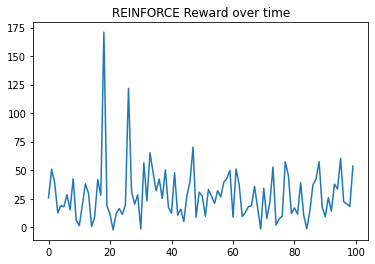

In [39]:
# plt.plot(losses)
# plt.title("REINFORCE loss")
plt.plot(rewards)
plt.title("REINFORCE Reward over time")

In [ ]:
# ! rm -rf /content/nle_data
# !ls -alh

In [40]:
torch.save(agent.policy_model.state_dict(), '/content/REINFORCE_AGENT_policy_state_dict')

DQN


In [37]:
env = gym.make("NetHackScore-v0")
agent = train_dqn(env, 200000)

episode_return -42.82000000000001 step 4999
mean loss 8.632760511040688
episode_return -43.189999999999976 step 9999
mean loss 7.5038028025627135
episode_return 16.769999999999456 step 10756
mean loss 4.182525602579116
episode_return -29.550000000001567 step 15756
mean loss 1.1967766416072845
episode_return -24.51000000000078 step 20260
mean loss 6.113639298280468
episode_return 5.140000000000037 step 20820
mean loss 6.703134147766978
episode_return -31.190000000002076 step 24380
mean loss 5.302425924668787
episode_return -42.530000000000065 step 29380
mean loss 5.924691850012168
episode_return 1.430000000000106 step 29978
mean loss 0.7616360372304917
episode_return -7.219999999999824 step 31257
mean loss 3.963486144542694
episode_return -35.46000000000214 step 36257
mean loss 3.4068328380584716
episode_return 28.87000000000167 step 39495
mean loss 4.635061608552933
episode_return -23.620000000001518 step 42466
mean loss 3.431641454398632
episode_return -47.15999999999919 step 47466
me

KeyboardInterrupt: ignored

In [18]:
torch.save(agent.model.state_dict(), '/content/DQN_AGENT_policy_state_dict')

# FINAL EVALUATION


In [51]:
import numpy as np
import gym
import nle
import random
import csv
import os

def run_episode(env,seed,episode_num):
    # create instance of MyAgent
    # from MyAgent import MyAgent
    # agent = MyAgent(env.observation_space, env.action_space,filepath='/content/REINFORCE_AGENT_model')


    done = False
    episode_return = 0.0
    state = env.reset()
    stats_list = [np.zeros(25),np.zeros(25)]
    steps = 0
    max_depth = 0
    while not done:
        # pass state to agent and let agent decide action
        action = agent.act(state)
        new_state, reward, done, _ = env.step(action)
        steps += 1
        episode_return += reward
        # Update list of episode stats
        stats_list = update_stat_list(stats_list,state)
        if stats_list[0][12] > max_depth:
            max_depth = stats_list[0][12]
        # Check if done
        if done:
            row = get_stats(stats_list[0],steps,max_depth,seed,episode_num)

        state = new_state
    return episode_return,row

def get_stats(stats,steps,max_depth,seed,episode_num):
    return [1, # end_status, 1 = episode ended correctly. This is assumed here
        stats[9], # This is the ingame score, which may differ from the total returns
        stats[20], # time
        steps,stats[10], # steps in this episode
        stats[19], # health points
        stats[18], # experience
        stats[13], # experience level
        stats[21], # gold
        "UNK", # name of killer. env doesn't store this, so just left as unknown
        max_depth, # The furthest depth the agent went this episode
        episode_num, # The number of the episode
        seed, # The env seed
        "nle.57."+str(episode_num-1)+".ttyrec"] # the name of the corresponding ttyrec file in stats.zip

def update_stat_list(stats_list,state):
    # Hacky stuff to get the right stats vector
    stats_list[0] = stats_list[1]
    stats_list[1] = list(state['blstats'])
    return stats_list



if __name__ == '__main__':
    # Directory
    dir = os.getcwd()

    # Seed
    seeds = [1,2,3,4,5]

    # Initialise environment
    env = gym.make("NetHackScore-v0")

    # Generate CSV
    stats_list = [['end_status','score','time','steps','hp','exp','exp_lev',
    'gold','hunger','killer_name','deepest_lev','episode','seeds','ttyrec']]

    # Run one episode
    rewards = []
    episode_num = 1
    for seed in seeds:
        env.seed(seed)
        seed_rewards = []
        reward,row = run_episode(env,seed,episode_num)
        stats_list.append(row)
        episode_num += 1
        rewards.append(reward)
    # Close environment and print average reward
    env.close()
    print("Average Reward: %f" %(np.mean(rewards)))

    # Write to csv
    # NOTE: Unfortunately, you will need to either rename each ttyrec file to
    #   match stats.csv or change the entry in stats.csv to point to the
    #   appropriate ttyrec file
    os.chdir(dir)
    file = open('stats.csv','w+',newline='')
    with file:
        writer = csv.writer(file)
        writer.writerows(stats_list)
    file.close()


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average Reward: 27.636000


Testing for submission


In [ ]:
class MyAgent():
    def __init__(self, observation_space, action_space, lr=1e-4, gamma=1, filepath="/workspace/Weights/REINFORCE_AGENT_model"):
        self.learning_rate = lr
        self.gamma = gamma
        self.observation_space = observation_space
        self.action_space = action_space

        stats_observation_space = self.observation_space["blstats"]
        map_observation_space = self.observation_space["glyphs"]
        # TODO Initialise your agent's models
        #
        self.policy_model = Policy(map_observation_space,stats_observation_space,self.action_space)
        self.optimiser = torch.optim.Adam(self.policy_model.parameters(), lr=self.learning_rate)
        self.log_probs = []

        # for example, if your agent had a Pytorch model it must be load here
        try:
            self.policy_model.load_state_dict(torch.load( filepath, map_location=torch.device(device)))
        except:
            pass
        # raise NotImplementedError

    def act(self, observation):
        # Perform processing to observation

        # TODO: return selected action
        map = observation["glyphs"]
        stats = observation["blstats"]

        x,y = stats[0], stats[1]

        n = 3
        s = 2
        padded_map = np.pad(map,n,'edge')
        aleph = padded_map[y-s+n:y+s+n+1,x-s+n:x+s+n+1].flatten()
        aleph = torch.from_numpy(aleph).float().to(device)
        aleph = aleph.unsqueeze(0)

        map = torch.from_numpy(map).float().to(device)
        map = map.unsqueeze(0)
        map = map.unsqueeze(1)
        stats = observation["blstats"]
        stats = torch.from_numpy(stats).float().to(device)
        stats= stats.unsqueeze(0)
        probs = self.policy_model.forward(map, stats, aleph)

        # choose actions according to probability
        
        p = probs.cpu().detach().numpy().flatten()
        action = np.random.choice(env.action_space.n, p=p)
        self.log_probs.append(torch.log(probs[action]))

        return action


    def update(self,rewards):
        self.optimiser.zero_grad()
        returns = self.compute_returns_naive_baseline(rewards)

        policy_gradient = []
        for i in range(len(returns)):
            # why is this negative?
            policy_gradient.append(-self.log_probs[i] * returns[i])
        policy_gradient = torch.stack(policy_gradient).sum()

        # back propagation
        policy_gradient.backward()
        self.optimiser.step()
        self.log_probs = []
        

    def compute_returns(self,rewards):
        returns = []
        for t in range(len(rewards)): 
            G = 0
            for k in range(t,len(rewards)):
                G = G + rewards[k] * self.gamma**(k-t-1)
            returns.append(G)

        return returns

    def compute_returns_naive_baseline(self,rewards):
        baseline = np.mean(rewards)
        std = np.std(rewards)

        returns = []
        for t in range(len(rewards)):
            G = 0
            for k in range(t,len(rewards)):
                # G = G + rewards[k] * gamma**(k-t-1)
                G = G + rewards[k]/(std+0.01) * self.gamma**(k-t-1) 
                # maybe try normalizing with returns
            
            G = G - baseline
            
            returns.append(G)
        return returns